# Bước 1: Import Modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
np.random.seed(0)

from pre_process import *
from utils import *

import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline

from torchmetrics.functional import char_error_rate

## Bước 2: Import data

In [4]:
path = '.'
data_path = path + '/Data_fixed'

In [5]:
train, train_fail_images = load_file(data_path+'/Train.txt')
dev, dev_fail_images = load_file(data_path+'/Val.txt')
test, test_fail_images = load_file(data_path+'/Test.txt')

In [6]:
train

,transcription,points,text,label,link,image
0,SPY/title/0,"[[237, 673], [595, 673], [595, 540], [237, 540]]",SPY,title,0,image_0.jpg
1,ROOM/title/1,"[[618, 621], [954, 621], [954, 540], [618, 540]]",ROOM,title,1,image_0.jpg
2,LỚP HỌC ĐIỆP VIÊN/title/2,"[[621, 677], [954, 677], [954, 636], [621, 636]]",LỚP HỌC ĐIỆP VIÊN,title,2,image_0.jpg
3,"""MANAMUSUME"" GRETE/title/3","[[694, 756], [952, 756], [952, 733], [694, 733]]","""MANAMUSUME"" GRETE",title,3,image_0.jpg
4,02/title/4,"[[851, 936], [956, 936], [956, 863], [851, 863]]",02,title,4,image_0.jpg
...,...,...,...,...,...,...
53787,100.000/other/4,"[[90, 414], [178, 399], [176, 383], [88, 399]]",100.000,other,4,image_999.jpg
53788,BẢN/other/5,"[[118, 425], [151, 420], [150, 407], [117, 412]]",BẢN,other,5,image_999.jpg
53789,truyện dài/other/6,"[[285, 411], [377, 420], [381, 407], [291, 398]]",truyện dài,other,6,image_999.jpg
53790,in lần thứ 27/other/7,"[[258, 423], [372, 433], [377, 421], [263, 410]]",in lần thứ 27,other,7,image_999.jpg


In [7]:
# Drop rows with NA label
train_NonNA = train.dropna(subset=['text', 'label']).reset_index(drop=True)
dev_NonNA = dev.dropna(subset=['text', 'label']).reset_index(drop=True)
test_NonNA = test.dropna(subset=['text', 'label']).reset_index(drop=True)

In [8]:
train_size = pd.read_csv('train_img_size.txt', names=['image', 'width', 'height'])
dev_size = pd.read_csv('val_img_size.txt', names=['image', 'width', 'height'])
test_size = pd.read_csv('test_img_size.txt', names=['image', 'width', 'height'])

## Bước 4: Xây dựng mô hình Scikit-Learn

### Tạo dữ liệu train và test

In [9]:
X_train = train_NonNA['text']
y_train = train_NonNA['label']
X_dev = dev_NonNA['text']
y_dev = dev_NonNA['label']
X_test = test_NonNA['text']
y_test = test_NonNA['label']

In [10]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [11]:
y_train_encode = le.transform(y_train)
y_dev_encode = le.transform(y_dev)
y_test_encode = le.transform(y_test)

In [12]:
tags = list(le.classes_)
tags

['author', 'other', 'publisher', 'title']

In [13]:
tf_transformer = TfidfVectorizer()
tf_transformer.fit(X_train)

TfidfVectorizer()

In [14]:
X_train_tf = tf_transformer.transform(X_train)
X_dev_tf = tf_transformer.transform(X_dev)
X_test_tf = tf_transformer.transform(X_test)

In [15]:
saved_model_path = path + '/saved_models'

In [16]:
tfidf_tokens = tf_transformer.get_feature_names_out()

In [17]:
len(tfidf_tokens)

5402

In [18]:
X_train = transform_tf_points(train_NonNA, X_train_tf, train_size)
X_dev = transform_tf_points(dev_NonNA, X_dev_tf, dev_size)
X_test = transform_tf_points(test_NonNA, X_test_tf, test_size)

### Mô hình Naive-Bayes

In [23]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train_encode)

MultinomialNB()

In [25]:
y_pred_nb = model_nb.predict(X_test)

In [26]:
print(accuracy_score(y_test_encode, y_pred_nb)*100)
print(f1_score(y_test_encode, y_pred_nb, average='macro')*100)

83.27645051194538
84.56167839257165


In [27]:
print(classification_report(y_test_encode, y_pred_nb, target_names=tags))

              precision    recall  f1-score   support

      author       0.92      0.82      0.87      1070
       other       0.84      0.65      0.73      1916
   publisher       0.90      0.99      0.94       939
       title       0.78      0.91      0.84      2814

    accuracy                           0.83      6739
   macro avg       0.86      0.84      0.85      6739
weighted avg       0.84      0.83      0.83      6739



### Logistic Regression

In [34]:
log_parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[1, 10, 100, 1000]}
logistic = LogisticRegression(max_iter = 250)

In [37]:
model_log = GridSearchCV(logistic, log_parameters, scoring = 'f1_macro', cv = 10)
model_log.fit(X_train, y_train_encode)

C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=250),
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1_macro')

In [38]:
model_log.best_params_

{'C': 100, 'penalty': 'l2'}

In [39]:
model_log = LogisticRegression(C=100, penalty='l2', max_iter = 1250)
model_log.fit(X_train, y_train_encode)

C:\Users\takhu\anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100, max_iter=1250)

In [40]:
y_pred_log = model_log.predict(X_test)

In [41]:
print(accuracy_score(y_test_encode, y_pred_log)*100)
print(f1_score(y_test_encode, y_pred_log, average='macro')*100)

92.63985754562991
93.45408335606093


In [42]:
print(classification_report(y_test_encode, y_pred_log, target_names=tags))

              precision    recall  f1-score   support

      author       0.94      0.91      0.93      1070
       other       0.91      0.87      0.89      1916
   publisher       0.99      1.00      0.99       939
       title       0.91      0.95      0.93      2814

    accuracy                           0.93      6739
   macro avg       0.94      0.93      0.93      6739
weighted avg       0.93      0.93      0.93      6739



### SVM

In [19]:
model_svm = svm.SVC(kernel='rbf', gamma='scale', C=10)
model_svm.fit(X_train, y_train_encode)

SVC(C=10)

In [20]:
y_pred_svm = model_svm.predict(X_test)

In [21]:
print(accuracy_score(y_test_encode, y_pred_svm)*100)
print(f1_score(y_test_encode, y_pred_svm, average='macro')*100)

95.31087698471583
95.89167634301481


In [22]:
print(classification_report(y_test_encode, y_pred_svm, target_names=tags))

              precision    recall  f1-score   support

      author       0.97      0.94      0.95      1070
       other       0.95      0.91      0.93      1916
   publisher       1.00      1.00      1.00       939
       title       0.93      0.97      0.95      2814

    accuracy                           0.95      6739
   macro avg       0.96      0.95      0.96      6739
weighted avg       0.95      0.95      0.95      6739



### Save models

In [23]:
#Save svm model
filename_svm = saved_model_path + '/SVM_model.sav'
pickle.dump(model_svm, open(filename_svm, 'wb'))

## Bước 5: Thang đo đánh giá CER (Character Error Rate)

In [20]:
filename_svm = saved_model_path + '/SVM_model.sav'
loaded_model_svm = pickle.load(open(filename_svm, 'rb'))

In [21]:
y_test_pred = loaded_model_svm.predict(X_test)

In [22]:
print(accuracy_score(y_test_encode, y_test_pred)*100)
print(f1_score(y_test_encode, y_test_pred, average='macro')*100)

95.31087698471583
95.89167634301481


In [24]:
test_NonNA['pre_label'] = y_test_pred

In [33]:
test_NonNA

,transcription,points,text,label,link,image,pre_label,Mean_y
0,CƯ XỬ NHƯ/title/0,"[[23, 175], [638, 153], [643, 52], [29, 75]]",CƯ XỬ NHƯ,title,0,image_1006.jpg,3,113.75
1,đàn bà/title/1,"[[503, 292], [933, 283], [933, 132], [536, 191]]",đàn bà,title,1,image_1006.jpg,3,224.50
2,SUY NGHĨ NHƯ/title/2,"[[19, 432], [838, 420], [839, 321], [23, 337]]",SUY NGHĨ NHƯ,title,2,image_1006.jpg,3,377.50
3,ĐÀN ÔNG/title/3,"[[472, 615], [932, 615], [932, 450], [477, 453]]",ĐÀN ÔNG,title,3,image_1006.jpg,3,533.25
4,NHÀ XUẤT BẢN/publisher/0,"[[125, 1386], [204, 1392], [204, 1377], [124, ...",NHÀ XUẤT BẢN,publisher,0,image_1006.jpg,2,1381.75
...,...,...,...,...,...,...,...,...
6734,Trần Ngọc Lâm dịch/other/0,"[[907, 1236], [1233, 1207], [1233, 1174], [906...",Trần Ngọc Lâm dịch,other,0,image_997.jpg,1,1205.50
6735,1980/other/1,"[[852, 1810], [973, 1804], [971, 1755], [852, ...",1980,other,1,image_997.jpg,1,1781.75
6736,BOOKS/other/2,"[[855, 1866], [973, 1859], [970, 1812], [854, ...",BOOKS,other,2,image_997.jpg,1,1838.25
6737,KHỞI NGUỒN TRI THỨC/other/3,"[[852, 1883], [974, 1877], [973, 1863], [853, ...",KHỞI NGUỒN TRI THỨC,other,3,image_997.jpg,1,1873.00


In [28]:
test_true = test_NonNA.groupby('image', as_index=False).apply(convert_df_to_text).rename(columns={None: 'transcript'})
test_true

,image,transcript
0,image_1006.jpg,CƯ XỬ NHƯ đàn bà SUY NGHĨ NHƯ ĐÀN ÔNG|||STEVE ...
1,image_1015.jpg,TÌM MÌNH TRONG THẾ GIỚI HẬU TUỔI THƠ|||ĐẶNG HO...
2,image_1026.jpg,trên đường băng|||Tony Buổi Sáng|||NHÀ XUẤT BẢ...
3,image_104.jpg,Tôi vỡ tan để ánh sáng ngập tràn|||BIANCA SPAR...
4,image_1048.jpg,"BẠN CHỈ CẦN SỐNG TỐT, TRỜI XANH TỰ AN BÀI|||Ko..."
...,...,...
782,image_961.jpg,Ngày xưa có một con Bò... Once upon a Cow|||CA...
783,image_965.jpg,IELTS NO VOCAB - NO WORRIES!|||VŨ HẢI NGƯỜI SÁ...
784,image_972.jpg,Bí mật của PHAN THIÊN ÂN||||||NXB THẾ GIỚI|||C...
785,image_98.jpg,SƯ TỬ VÀ CHUỘT NHẮT The Lion and the Mouse|||B...


In [30]:
test_NonNA['Mean_y'] = test_NonNA['points'].map(lambda x: (x[0][1]+x[1][1]+x[2][1]+x[3][1])/4)

In [34]:
test_NonNA['pre_label'] = test_NonNA['pre_label'].map({0: 'author', 1: 'other', 2: 'publisher', 3: 'title'})

In [35]:
test_pre = test_NonNA.groupby('image', as_index=False).apply(convert_result_to_text).rename(columns={None: 'transcript'})
test_pre

,image,transcript
0,image_1006.jpg,CƯ XỬ NHƯ đàn bà SUY NGHĨ NHƯ ĐÀN ÔNG|||STEVE ...
1,image_1015.jpg,TÌM MÌNH TRONG THẾ GIỚI HẬU TUỔI THƠ|||ĐẶNG HO...
2,image_1026.jpg,trên đường băng|||Tony Buổi Sáng|||NHÀ XUẤT BẢ...
3,image_104.jpg,Tôi vỡ tan để ánh sáng ngập tràn|||BIANCA SPAR...
4,image_1048.jpg,"BẠN CHỈ CẦN SỐNG TỐT, TRỜI XANH TỰ AN BÀI|||Ko..."
...,...,...
782,image_961.jpg,xưa Ngày một có Bò... con Once upon a Cow|||CA...
783,image_965.jpg,IELTS NO VOCAB - NO WORRIES!|||VŨ HẢI NGƯỜI SÁ...
784,image_972.jpg,Bí mật của PHAN THIÊN ÂN||||||NXB THẾ GIỚI|||C...
785,image_98.jpg,SƯ TỬ VÀ CHUỘT NHẮT The Lion and the Mouse|||B...


In [36]:
char_error_rate(test_true['transcript'], test_pre['transcript'])

tensor(0.1159)

## 6 Phân tích lỗi

In [48]:
loaded_model_svm = pickle.load(open(filename_svm, 'rb'))

In [49]:
y_dev_pred = loaded_model_svm.predict(X_dev_tf)

In [50]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_dev_encode, y_dev_pred)

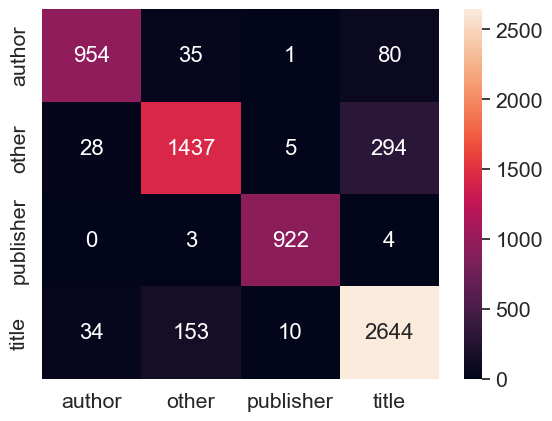

In [51]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cf, range(4), range(4))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', 
           xticklabels=tags, yticklabels=tags) 
plt.show()

### Check the errors between `title` and `other`

In [53]:
failed_examples(dev_segment, true=3, predict=1, y_true=y_dev_encode, y_pred=y_dev_pred)

,transcription,points,text,label,link,image
8,CHA MẸ/title/0,"[[268, 378], [710, 388], [712, 238], [271, 240]]",CHA_MẸ,title,0,image_1136.jpg
10,15 PHÚT - 45 PHÚT - HỌC KÌ/title/3,"[[167, 643], [762, 659], [760, 622], [168, 614]]",15 PHÚT - 45 PHÚT - HỌC_KÌ,title,3,image_1149.jpg
25,tuổi/title/3,"[[375, 770], [473, 769], [474, 722], [374, 726]]",tuổi,title,3,image_1303.jpg
26,LUYỆN/title/3,"[[522, 670], [802, 669], [795, 535], [516, 552]]",LUYỆN,title,3,image_1304.jpg
28,RICH/title/1,"[[214, 602], [696, 574], [682, 390], [208, 405]]",RICH,title,1,image_1340.jpg
...,...,...,...,...,...,...
604,TÂM HỒN/title/1,"[[1010, 1942], [2342, 1892], [2301, 1449], [99...",TÂM_HỒN,title,1,image_7720.jpg
611,KINH/title/2,"[[582, 609], [1255, 609], [1255, 664], [582, 6...",KINH,title,2,image_790.jpg
614,Bé thông minh/title/0,"[[410, 694], [753, 694], [753, 741], [410, 741]]",Bé thông_minh,title,0,image_816.jpg
615,Smart babies can get/title/4,"[[433, 925], [721, 917], [722, 945], [435, 950]]",Smart babies can get,title,4,image_816.jpg


In [54]:
failed_examples(dev_segment, true=1, predict=3, y_true=y_dev_encode, y_pred=y_dev_pred)

,transcription,points,text,label,link,image
0,Ai/other/1,"[[174, 519], [186, 519], [186, 505], [175, 505]]",Ai,other,1,image_1062.jpg
1,là/other/3,"[[176, 559], [186, 559], [188, 547], [177, 546]]",là,other,3,image_1062.jpg
2,người/other/4,"[[161, 580], [186, 581], [187, 567], [163, 566]]",người,other,4,image_1062.jpg
3,giàu/other/5,"[[166, 600], [185, 601], [186, 588], [167, 587]]",giàu,other,5,image_1062.jpg
7,KN/other/0,"[[701, 508], [803, 498], [800, 449], [697, 460]]",KN,other,0,image_1112.jpg
...,...,...,...,...,...,...
640,CUỘC ĐỜI/other/2,"[[993, 1277], [1117, 1281], [1117, 1251], [993...",CUỘC_ĐỜI,other,2,image_959.jpg
641,NGƯỜI/other/4,"[[1012, 1336], [1097, 1339], [1097, 1312], [10...",NGƯỜI,other,4,image_959.jpg
643,và/other/10,"[[533, 530], [543, 525], [537, 517], [529, 520]]",và,other,10,image_967.jpg
644,IN/other/4,"[[484, 490], [487, 477], [474, 475], [472, 489]]",IN,other,4,image_967.jpg


### Check the errors between `title` and `author`

In [55]:
failed_examples(dev_segment, true=0, predict=3, y_true=y_dev_encode, y_pred=y_dev_pred)

,transcription,points,text,label,link,image
6,Thành Đức Trung | Đỗ Thị Kim Dung | Nguyễn Thị...,"[[369, 296], [650, 287], [648, 273], [368, 282]]",Thành Đức Trung | Đỗ_Thị_Kim_Dung | Nguyễn_Thị...,author,1,image_1099.jpg
33,Takaharu Yasumoto/author/0,"[[461, 242], [738, 242], [738, 213], [461, 213]]",Takaharu_Yasumoto,author,0,image_138.jpg
62,STEPHANIEL/author/2,"[[1242, 1017], [1592, 1055], [1586, 1109], [12...",STEPHANIEL,author,2,image_1608.jpg
86,NICK VUJICIC/author/0,"[[58, 31], [535, 32], [533, 85], [61, 81]]",NICK VUJICIC,author,0,image_220.jpg
90,ART MARKMAN/author/0,"[[272, 342], [393, 313], [393, 327], [275, 357]]",ART MARKMAN,author,0,image_226.jpg
...,...,...,...,...,...,...
629,"(LÀM GIÀU TỪ CHỨNG KHOÁN"" VÀ/author/4","[[291, 222], [532, 222], [532, 201], [291, 201]]","( LÀM_GIÀU TỪ CHỨNG_KHOÁN "" VÀ",author,4,image_83.jpg
632,ĐẶNG/author/0,"[[262, 439], [484, 297], [553, 351], [350, 493]]",ĐẶNG,author,0,image_832.jpg
637,Thiết kế:/author/5,"[[57, 779], [123, 779], [123, 760], [57, 760]]",Thiết_kế :,author,5,image_92.jpg
638,Trish Papadakos/author/6,"[[58, 812], [178, 812], [178, 793], [58, 793]]",Trish_Papadakos,author,6,image_92.jpg


In [56]:
failed_examples(dev_segment, true=3, predict=0, y_true=y_dev_encode, y_pred=y_dev_pred)

,transcription,points,text,label,link,image
5,CHÍ PHÈO/title/0,"[[202, 1083], [770, 1090], [783, 971], [212, 9...",CHÍ PHÈO,title,0,image_1088.jpg
14,arakawa/title/6,"[[848, 890], [993, 890], [993, 861], [848, 861]]",arakawa,title,6,image_117.jpg
19,DU KÍCH/title/1,"[[190, 632], [811, 620], [800, 472], [195, 485]]",DU_KÍCH,title,1,image_1220.jpg
27,TRÍ/title/4,"[[676, 770], [816, 763], [807, 654], [668, 662]]",TRÍ,title,4,image_1304.jpg
47,HANYU JIAOCHENG/title/0,"[[734, 877], [1141, 877], [1141, 840], [734, 8...",HANYU JIAOCHENG,title,0,image_148.jpg
55,FUJIKO F FUJIO/title/2,"[[439, 421], [780, 421], [780, 382], [439, 382]]",FUJIKO F FUJIO,title,2,image_154.jpg
78,mai/title/1,"[[1252, 1010], [1527, 1080], [1480, 1129], [12...",mai,title,1,image_1935.jpg
79,mai/title/1,"[[1097, 442], [1439, 412], [1445, 476], [1103,...",mai,title,1,image_1938.jpg
81,TRÍ/title/1,"[[993, 809], [1301, 890], [1263, 1029], [954, ...",TRÍ,title,1,image_1986.jpg
82,TRÍ/title/1,"[[696, 867], [1055, 769], [1103, 940], [751, 1...",TRÍ,title,1,image_1995.jpg


### Check the errors between `author` and `other`

In [57]:
failed_examples(dev_segment, true=0, predict=1, y_true=y_dev_encode, y_pred=y_dev_pred)

,transcription,points,text,label,link,image
23,Mai Ngọc (Hiệu đính)/author/1,"[[410, 227], [529, 230], [530, 218], [408, 214]]",Mai_Ngọc ( Hiệu_đính ),author,1,image_1275.jpg
51,ĐẠI HỌC NGÔN NGỮ BẮC KINH/author/0,"[[469, 114], [959, 114], [959, 73], [469, 73]]",ĐẠI_HỌC NGÔN_NGỮ BẮC KINH,author,0,image_148.jpg
143,Tác giả cuốn sách bán chạy NGUYÊN LÝ 80...,"[[143, 160], [759, 154], [760, 198], [148, 199]]",Tác giả cuốn sách bán chạy NGUYÊN LÝ 80/20,author,1,image_341.jpg
145,Thành/author/0,"[[2050, 100], [2604, 107], [2604, 259], [2075,...",_Thành,author,0,image_3445.jpg
155,Hào/author/0,"[[826, 729], [1038, 650], [1064, 743], [881, 8...",Hào,author,0,image_3637.jpg
157,Hào/author/0,"[[1685, 824], [1967, 835], [1963, 990], [1683,...",Hào,author,0,image_3641.jpg
158,TÁC GIẢ/author/0,"[[1610, 1188], [2046, 1169], [2054, 1254], [16...",TÁC_GIẢ,author,0,image_3654.jpg
159,TÁC GIẢ/author/0,"[[2337, 91], [2826, 86], [2818, 205], [2349, 2...",TÁC_GIẢ,author,0,image_3655.jpg
160,TÁC GIẢ/author/0,"[[1651, 758], [2166, 766], [2165, 894], [1648,...",TÁC_GIẢ,author,0,image_3662.jpg
169,TÁC GIẢ CUỐN SÁCH BÁN CHẠY THEO THE NEW ...,"[[99, 63], [427, 64], [424, 78], [102, 79]]",TÁC GIẢ CUỐN SÁCH BÁN CHẠY THEO THE NEW ...,author,1,image_378.jpg


In [58]:
failed_examples(dev_segment, true=1, predict=0, y_true=y_dev_encode, y_pred=y_dev_pred)

,transcription,points,text,label,link,image
18,(Biên soạn)/other/0,"[[415, 233], [534, 227], [533, 201], [411, 207]]",( Biên_soạn ),other,0,image_1206.jpg
22,"(Foreword by BERNIES S. SIEGEL, M. D.)/other/0","[[358, 1080], [626, 1069], [625, 1049], [357, ...","( Foreword by BERNIES S. SIEGEL , M. D . )",other,0,image_1230.jpg
35,tiểu/other/0,"[[844, 503], [888, 503], [888, 479], [844, 479]]",tiểu,other,0,image_14.jpg
52,Biên soạn/other/0,"[[181, 595], [278, 594], [277, 576], [182, 576]]",Biên_soạn,other,0,image_1538.jpg
147,Nguyên Giám đốc Marketing Vinamilk/other/3,"[[516, 944], [835, 944], [835, 923], [516, 923]]",Nguyên Giám_đốc Marketing_Vinamilk,other,3,image_35.jpg
166,Và John Fleming và Kim Kiyosaki/other/3,"[[30, 637], [319, 637], [318, 662], [35, 659]]",Và John_Fleming và Kim_Kiyosaki,other,3,image_377.jpg
246,ARGOPREP/other/6,"[[686, 93], [868, 105], [855, 135], [681, 128]]",ARGOPREP,other,6,image_4235.jpg
301,PHẠM THỊ QUẾ ANH dịch/other/0,"[[344, 1134], [488, 1134], [488, 1162], [344, ...",PHẠM THỊ QUẾ ANH dịch,other,0,image_476.jpg
324,Người sáng lập công ty Kyocera và công ty KDDI...,"[[532, 954], [2163, 930], [2166, 1016], [534, ...","Người sáng_lập công_ty Kyocera và công_ty KDDI ,",other,0,image_5014.jpg
325,nguyên Chủ tịch Hãng hàng không Nhật Bản (JAL)...,"[[503, 1064], [2203, 1029], [2200, 1121], [507...",nguyên Chủ_tịch Hãng hàng_không Nhật_Bản ( JAL ),other,1,image_5014.jpg


### Nhận xét: 
- Phần lớn các lỗi nhầm lẫn đều khó phân biệt và không thể chỉ dựa vào text. Có lẽ việc đưa thêm tọa độ bounding box vào input sẽ cho ra kết quả chính xác hơn.
- Bộ dữ liệu còn một số vấn đề, nhiều trường hợp cùng 1 tình huống nhưng kết quả lại khác nhau, đặc biệt là các tình huống giữa 2 nhãn `author` và `other`